In [1]:
#Setup & Import Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from imblearn.over_sampling import SMOTE

import warnings
warnings.filterwarnings('ignore')


In [2]:
#Load Data and Check for Missing Values
df = pd.read_csv('HR_comma_sep.csv')  
print(df.info())
print(df.isnull().sum())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   satisfaction_level     14999 non-null  float64
 1   last_evaluation        14999 non-null  float64
 2   number_project         14999 non-null  int64  
 3   average_montly_hours   14999 non-null  int64  
 4   time_spend_company     14999 non-null  int64  
 5   Work_accident          14999 non-null  int64  
 6   left                   14999 non-null  int64  
 7   promotion_last_5years  14999 non-null  int64  
 8   sales                  14999 non-null  object 
 9   salary                 14999 non-null  object 
dtypes: float64(2), int64(6), object(2)
memory usage: 1.1+ MB
None
satisfaction_level       0
last_evaluation          0
number_project           0
average_montly_hours     0
time_spend_company       0
Work_accident            0
left                     0
promotion_l

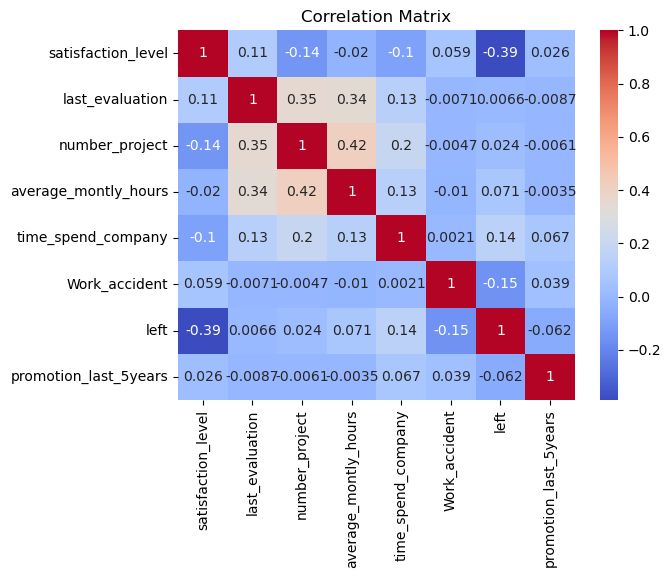

In [4]:
#Exploratory Data Analysis (EDA)
# Automatically select only numeric columns
import seaborn as sns
import matplotlib.pyplot as plt

# Select only numeric columns for correlation
numeric_df = df.select_dtypes(include='number')

# Correlation Heatmap
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()


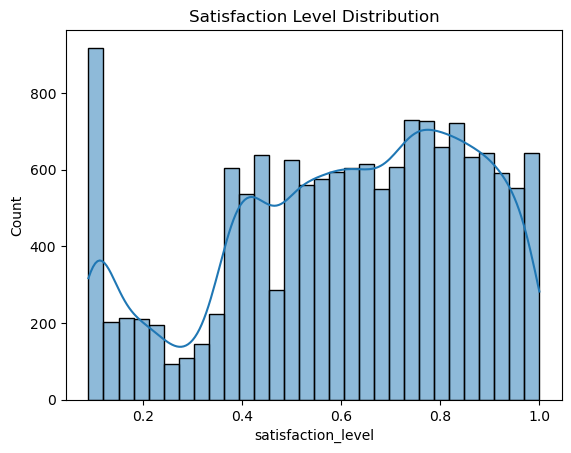

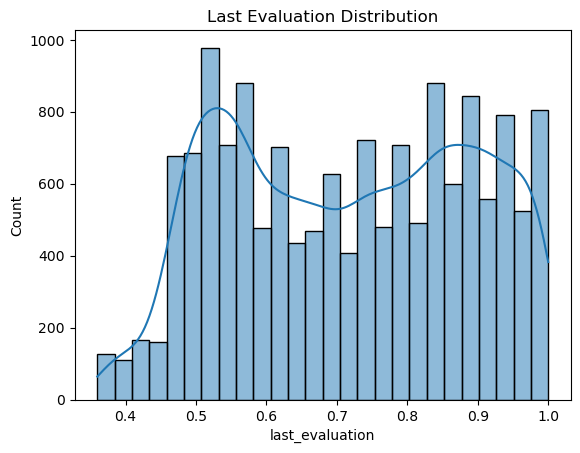

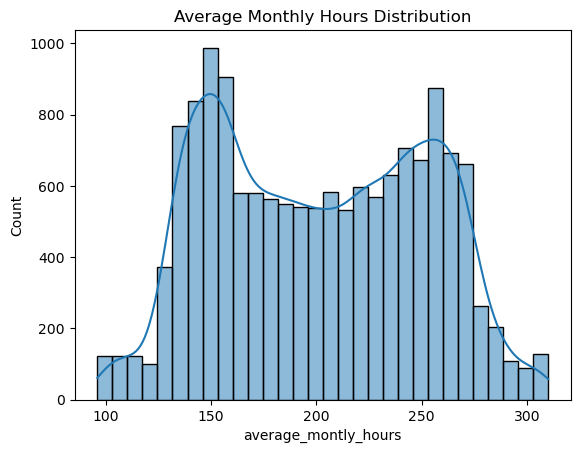

In [5]:
#Distribution Plots
sns.histplot(df['satisfaction_level'], kde=True)
plt.title("Satisfaction Level Distribution")
plt.show()

sns.histplot(df['last_evaluation'], kde=True)
plt.title("Last Evaluation Distribution")
plt.show()

sns.histplot(df['average_montly_hours'], kde=True)
plt.title("Average Monthly Hours Distribution")
plt.show()


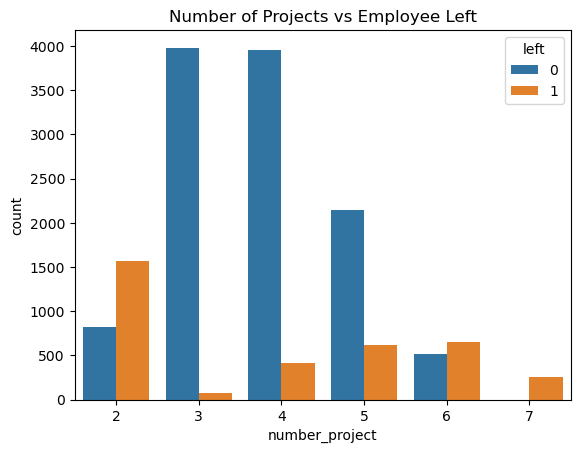

In [6]:
#Barplot of Project Count by Turnover
sns.countplot(x='number_project', hue='left', data=df)
plt.title("Number of Projects vs Employee Left")
plt.show()


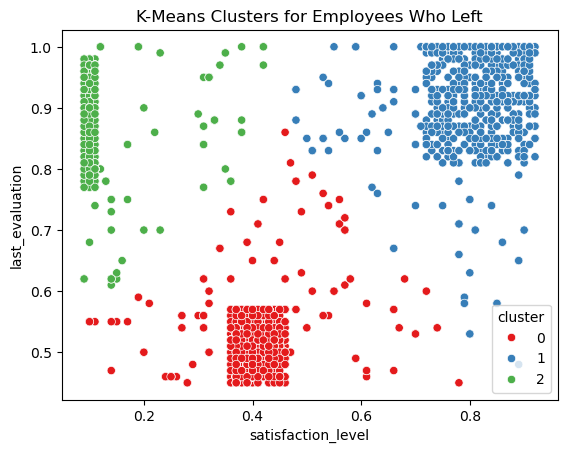

In [7]:
#Clustering Employees Who Left
from sklearn.cluster import KMeans

left_df = df[df['left'] == 1][['satisfaction_level', 'last_evaluation']]
kmeans = KMeans(n_clusters=3, random_state=42)
left_df['cluster'] = kmeans.fit_predict(left_df)

sns.scatterplot(x='satisfaction_level', y='last_evaluation', hue='cluster', data=left_df, palette='Set1')
plt.title("K-Means Clusters for Employees Who Left")
plt.show()


In [8]:
#Handle Class Imbalance with SMOTE
 #Preprocessing Categorical Features
categorical = df.select_dtypes(include='object')
numerical = df.select_dtypes(exclude='object')

categorical_encoded = pd.get_dummies(categorical, drop_first=True)
df_processed = pd.concat([numerical, categorical_encoded], axis=1)

X = df_processed.drop('left', axis=1)
y = df_processed['left']


In [9]:
#Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=123)


In [10]:
#Apply SMOTE
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X_train, y_train)


In [11]:
#Model Training with Cross-Validation
models = {
    'Logistic Regression': LogisticRegression(),
    'Random Forest': RandomForestClassifier(),
    'Gradient Boosting': GradientBoostingClassifier()
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)

for name, model in models.items():
    scores = cross_val_score(model, X_res, y_res, cv=cv, scoring='accuracy')
    print(f"{name} Cross-Validation Accuracy: {scores.mean():.4f}")


Logistic Regression Cross-Validation Accuracy: 0.7795
Random Forest Cross-Validation Accuracy: 0.9850
Gradient Boosting Cross-Validation Accuracy: 0.9634



Logistic Regression Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.76      0.83      2286
           1       0.50      0.75      0.60       714

    accuracy                           0.76      3000
   macro avg       0.70      0.76      0.72      3000
weighted avg       0.81      0.76      0.78      3000

Logistic Regression Confusion Matrix:
 [[1747  539]
 [ 176  538]]
Logistic Regression AUC: 0.8171

Random Forest Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99      2286
           1       0.97      0.98      0.98       714

    accuracy                           0.99      3000
   macro avg       0.98      0.98      0.98      3000
weighted avg       0.99      0.99      0.99      3000

Random Forest Confusion Matrix:
 [[2268   18]
 [  16  698]]
Random Forest AUC: 0.9949

Gradient Boosting Classification Report:
               precision    recall  

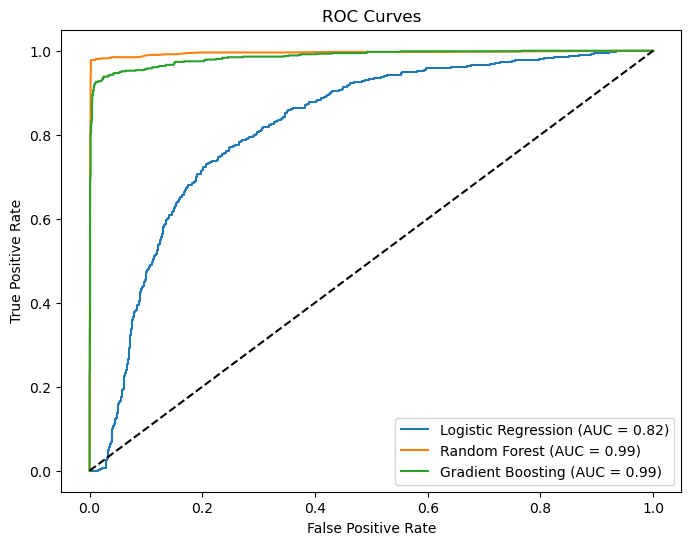

In [12]:
#Evaluation Metrics & Best Model Selection
def evaluate_model(model, name):
    model.fit(X_res, y_res)
    y_pred = model.predict(X_test)
    print(f"\n{name} Classification Report:\n", classification_report(y_test, y_pred))

    cm = confusion_matrix(y_test, y_pred)
    print(f"{name} Confusion Matrix:\n", cm)

    y_proba = model.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, y_proba)
    print(f"{name} AUC: {auc:.4f}")

    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {auc:.2f})')

plt.figure(figsize=(8, 6))
for name, model in models.items():
    evaluate_model(model, name)

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves")
plt.legend()
plt.show()


Zone
Green     2083
Red        615
Yellow     222
Orange      80
Name: count, dtype: int64


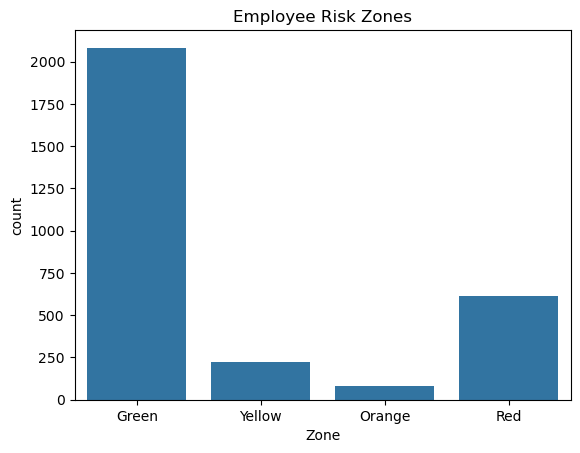

In [13]:
#Retention Strategy Using Prediction Probabilities
best_model = GradientBoostingClassifier().fit(X_res, y_res)  # Replace with chosen best
y_prob = best_model.predict_proba(X_test)[:, 1]

def categorize_risk(score):
    if score < 0.2:
        return 'Green'
    elif score < 0.6:
        return 'Yellow'
    elif score < 0.9:
        return 'Orange'
    else:
        return 'Red'

risk_zones = pd.DataFrame({'Probability': y_prob})
risk_zones['Zone'] = risk_zones['Probability'].apply(categorize_risk)

print(risk_zones['Zone'].value_counts())

sns.countplot(x='Zone', data=risk_zones, order=['Green', 'Yellow', 'Orange', 'Red'])
plt.title("Employee Risk Zones")
plt.show()
